In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba 
import jieba.analyse
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer # 用bag of word建造每篇文章的詞向量
from sklearn.feature_extraction.text import TfidfVectorizer # 用TFIDF建造每篇文章的詞向量
import gensim
from gensim import corpora , models

### 數據來源：http://www.sogou.com/labs/resource/ca.php 

In [2]:
df_news = pd.read_table('./data/val.txt' , 
                        names = ['category' , 'theme' , 'URL' , 'content'] , 
                        encoding = 'utf-8')
df_news = df_news.dropna()
df_news.head()

,category,theme,URL,content
0,汽车,新辉腾 ４．２ Ｖ８ ４座加长Ｉｎｄｉｖｉｄｕａｌ版２０１１款 最新报价,http://auto.data.people.com.cn/model_15782/,经销商 电话 试驾／订车Ｕ憬杭州滨江区江陵路１７８０号４００８－１１２２３３转５８６４＃保常...
1,汽车,９１８ Ｓｐｙｄｅｒ概念车,http://auto.data.people.com.cn/prdview_165423....,呼叫热线 ４００８－１００－３００ 服务邮箱 ｋｆ＠ｐｅｏｐｌｅｄａｉｌｙ．ｃｏｍ．ｃｎ
2,汽车,日内瓦亮相 ＭＩＮＩ性能版／概念车－１．６Ｔ引擎,http://auto.data.people.com.cn/news/story_5249...,ＭＩＮＩ品牌在二月曾经公布了最新的ＭＩＮＩ新概念车Ｃｌｕｂｖａｎ效果图，不过现在在日内瓦车展...
3,汽车,清仓大甩卖一汽夏利Ｎ５威志Ｖ２低至３．３９万,http://auto.data.people.com.cn/news/story_6144...,清仓大甩卖！一汽夏利Ｎ５、威志Ｖ２低至３．３９万＝日，启新中国一汽强势推出一汽夏利Ｎ５、威志...
4,汽车,大众敞篷家族新成员 高尔夫敞篷版实拍,http://auto.data.people.com.cn/news/story_5686...,在今年３月的日内瓦车展上，我们见到了高尔夫家族的新成员，高尔夫敞篷版，这款全新敞篷车受到了众...


###  分詞：使用結吧分詞器

In [3]:
content = df_news.content.values.tolist()
print(content[2000])

６月２４日，是梅西２５岁的生日。《世界体育报》特地为梅西提前做了个专题，梅西手持一件印有他姓氏和２５号号码的巴塞罗那球衣，跳蚤提前许下了生日愿望。！拔颐窍氯季的目标，和之前永远相同，那就是踢出漂亮的足球，并且赢得尽可能多的冠军奖杯。”梅西许愿，“如果能再次赢得西甲和欧冠冠军的话，那会非常美妙，我们将会努力再给球迷带来一次双冠王的喜悦。下赛季我的儿子将会出生，对于我来说，这将是一个特殊的赛季。我希望，下赛季对于巴萨而言也会是一个特殊的赛季。”６杂诎腿，梅西永远感激于心：“我永远感激巴萨为我所做的一切，我的病曾经需要巨额治疗资金，巴萨照顾好了我生活的方方面面，巴萨给了我踢足球的机会。这太美妙了，因为巴萨让我梦想成真。”＜唇２５岁的梅西，一共为巴萨出场３２９次，跳蚤打进２５３球，并且已经连续拿到了３个金球奖杯。在团队荣誉方面，梅西代表巴萨和阿根廷国青队拿到了２１个冠军头衔。在个人荣誉方面，梅西也拿到了１３个奖项，其中包括３个金球奖、１个世界足球先生奖项，２个欧洲金靴奖、２个西甲金靴奖、４个欧冠金靴和１个世青赛金靴。除了世界杯和美洲杯外，梅西拿到了能拿的一切荣誉。在２５岁的年龄段上，梅西的成就已经超越了贝利、克鲁伊夫、马拉多纳和迪斯蒂法诺这四大球王。＃玻邓甑谋蠢虽然拿到了世界杯冠军，但总奖杯数仅为１８个，比梅西少３个。在个人荣誉方面，贝利在国家队只拿了１９５９年美洲杯金靴。贝利的绝大多数个人荣誉，都是他在巴西国内联赛或者州内部联赛的金靴。２５岁的克鲁伊夫拿到了８个冠军和２个个人奖项，２５岁的马拉多纳拿到了５个冠军和６个个人奖项，２５岁的迪斯蒂法诺拿到了４个冠军和２个个人奖项。无论比团队荣誉还是个人奖项，梅西都是这一年龄段的史上最佳。


In [4]:
# 使用jieba對每邊文章分詞
content_S = [] # content_S 收集所有分詞後的結果
for line in content:
    current_segment = jieba.lcut(line)
    if len(current_segment) > 1 and current_segment != '\r\n': # '\r\n' => 換行
        content_S.append(current_segment) 

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\peng\AppData\Local\Temp\jieba.cache
Loading model cost 1.227 seconds.
Prefix dict has been built succesfully.


In [5]:
'|'.join(content_S[2000]) # 將呈現分詞後的結果，並以'|'做分隔

'６|月|２|４|日|，|是|梅西|２|５|岁|的|生日|。|《|世界|体育报|》|特地|为|梅西|提前|做|了|个|专题|，|梅西|手持|一件|印有|他|姓氏|和|２|５|号|号码|的|巴塞罗那|球衣|，|跳蚤|提前|许下|了|生日|愿望|。|！|拔|颐窍|氯季|的|目标|，|和|之前|永远|相同|，|那|就是|踢|出|漂亮|的|足球|，|并且|赢得|尽可能|多|的|冠军|奖杯|。|”|梅西|许愿|，|“|如果|能|再次|赢得|西甲|和|欧冠|冠军|的话|，|那会|非常|美妙|，|我们|将会|努力|再|给|球迷|带来|一次|双冠王|的|喜悦|。|下|赛季|我|的|儿子|将会|出生|，|对于|我|来说|，|这|将|是|一个|特殊|的|赛季|。|我|希望|，|下|赛季|对于|巴萨|而言|也|会|是|一个|特殊|的|赛季|。|”|６|杂|诎|腿|，|梅西|永远|感激|于心|：|“|我|永远|感激|巴萨|为|我|所|做|的|一切|，|我|的|病|曾经|需要|巨额|治疗|资金|，|巴萨|照顾|好|了|我|生活|的|方方面面|，|巴萨|给|了|我|踢足球|的|机会|。|这太|美妙|了|，|因为|巴萨|让|我|梦想成真|。|”|＜|唇|２|５|岁|的|梅西|，|一共|为|巴萨|出场|３|２|９|次|，|跳蚤|打|进|２|５|３|球|，|并且|已经|连续|拿到|了|３|个|金球奖|杯|。|在|团队|荣誉|方面|，|梅西|代表|巴萨|和|阿根廷|国青队|拿到|了|２|１|个|冠军|头衔|。|在|个人|荣誉|方面|，|梅西|也|拿到|了|１|３|个|奖项|，|其中|包括|３|个|金球奖|、|１|个|世界足球|先生|奖项|，|２|个|欧洲|金靴奖|、|２|个|西甲|金靴奖|、|４|个|欧冠|金靴|和|１|个|世青赛|金靴|。|除了|世界杯|和|美洲杯|外|，|梅西|拿到|了|能|拿|的|一切|荣誉|。|在|２|５|岁|的|年龄段|上|，|梅西|的|成就|已经|超越|了|贝利|、|克鲁伊夫|、|马拉多纳|和|迪|斯蒂法|诺|这|四大|球王|。|＃|玻邓|甑|谋蠢|虽然|拿到|了|世界杯|冠军|，|但|总|奖杯|数仅|为|１|８|个|，|比梅|西少|３|个|。|在|个人|荣誉|方面|，|贝利|在|国家队|只|拿|了|１|９|５|９|年|美洲杯|金靴|。|贝利|的|绝大多数|个人|荣誉|，|

In [6]:
# 呈現分詞後的結果
df_content = pd.DataFrame({'content_S' : content_S})
df_content.head(10)

,content_S
0,"[经销商, , 电话, , 试驾, ／, 订车, Ｕ, 憬, 杭州, 滨江区, 江陵, ..."
1,"[呼叫, 热线, , ４, ０, ０, ８, －, １, ０, ０, －, ３, ０, ０..."
2,"[Ｍ, Ｉ, Ｎ, Ｉ, 品牌, 在, 二月, 曾经, 公布, 了, 最新, 的, Ｍ, Ｉ..."
3,"[清仓, 大, 甩卖, ！, 一汽, 夏利, Ｎ, ５, 、, 威志, Ｖ, ２, 低至, ..."
4,"[在, 今年, ３, 月, 的, 日内瓦, 车展, 上, ，, 我们, 见到, 了, 高尔夫..."
5,"[经销商, , 电话, , 试驾, ／, 订车, ８, 仕, 嗍, √, 焖, 市, 秦..."
6,"[经销商, , 电话, , 试驾, ／, 订车, ９, 愣省, 东莞市, 南, 城区, ..."
7,"[目前, 很多, 自主, 品牌, 的, 崛起, 都, 是从, 模仿, 世界, 老牌, 名车,..."
8,"[华泰, 在, 推出, 自主, 轿车, Ｂ, １, １, 后, ，, 又, 一款, 自主, ..."
9,"[爱美, 之心, 人皆有之, ，, 汽车, 的, 外观, 炫感度, 所, 形成, 的, 冲击..."


In [7]:
# 讀取停用詞檔案
f = open('stopwords.txt' , 'r' , encoding = 'utf-8')
lines = f.readlines()
stopwords = []
for line in lines:
    stopwords.append(line.split('\n')[0])
    
stopwords = pd.DataFrame({'stopwords' : stopwords})

In [8]:
def drop_stopwords(contents , stopwords):
    contents_clean = []
    all_words = [] # 把所有不是停用詞的詞收集起來
    for line in contents:
        line_clean = []
        for word in line:
            if word not in stopwords:
                line_clean.append(word)
                all_words.append(str(word))       
        contents_clean.append(line_clean)
    return contents_clean , all_words
        
contents = df_content['content_S'].tolist()    
stopwords = stopwords['stopwords'].tolist()
contents_clean , all_words = drop_stopwords(contents , stopwords)

In [9]:
# 呈現去掉停用詞後的結果
df_content = pd.DataFrame({'contents_clean' : contents_clean})
df_content.head(10)

,contents_clean
0,"[经销商, 电话, 试驾, 订车, Ｕ, 憬, 杭州, 滨江区, 江陵, 路, 号, 转, ..."
1,"[呼叫, 热线, 服务, 邮箱, ｋ, ｆ, ｐ, ｅ, ｏ, ｐ, ｌ, ｅ, ｄ, ａ,..."
2,"[Ｍ, Ｉ, Ｎ, Ｉ, 品牌, 二月, 公布, 最新, Ｍ, Ｉ, Ｎ, Ｉ, 新, 概念..."
3,"[清仓, 甩卖, 一汽, 夏利, Ｎ, 威志, Ｖ, 低至, 万, 启新, 中国, 一汽, ..."
4,"[日内瓦, 车展, 见到, 高尔夫, 家族, 新, 成员, 高尔夫, 敞篷版, 款, 全新,..."
5,"[经销商, 电话, 试驾, 订车, 仕, 嗍, √, 焖, 市, 秦城区, 岷山, 路, 号..."
6,"[经销商, 电话, 试驾, 订车, 愣省, 东莞市, 南, 城区, 莞太, 大道, 白马, ..."
7,"[自主, 品牌, 崛起, 是从, 模仿, 世界, 老牌, 名车, 一件, 坏事, 这是, 一..."
8,"[华泰, 推出, 自主, 轿车, Ｂ, 一款, 自主, Ｓ, Ｕ, Ｖ, 宝利格, 下旬, ..."
9,"[爱美, 之心, 人皆有之, 汽车, 外观, 炫感度, 冲击力, 第一眼, 接触, 消费者,..."


In [10]:
# 計算詞頻_way1
words_count = {}
for word in all_words:
    if word in words_count.keys():
        words_count[word] += 1
    else:
        words_count[word] = 1

# 把詞頻排序並整理成dataframe   
words_count = sorted(words_count.items() , key = lambda s : s [1] , reverse = True )
words_count = pd.DataFrame(words_count)
words_count.columns = ['all_word' , 'count']

# # 計算詞頻_way2
# words_count = {}
# for word in all_words:
#     if word in words_count.keys():
#         words_count[word] += 1
#     else:
#         words_count[word] = 1

# # 把詞頻整理成dataframe並排序
# words_count = pd.DataFrame.from_dict(words_count , orient='index')       
# words_count.columns = ['count']
# words_count['all_word'] = words_count.index
# words_count = words_count.sort_values(by = 'count' ,ascending=False)
# words_count = words_count.reset_index(drop = True)    

### 顯示文字雲

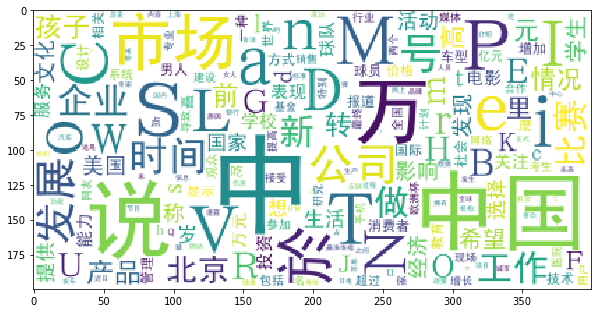

In [11]:
fig = plt.figure(figsize = (10, 10))
wordcloud = WordCloud(font_path = './data/simhei.ttf' ,
                      background_color = 'white' , 
                      max_font_size = 80 , 
                      random_state = 10)
word_frequence = {x[0] : x[1] for x in words_count.head(200).values}
wordcloud = wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

###  提取關鍵詞

In [12]:
index = 2400 # 要提取 df_news['content'][2400] 的 5個關鍵詞
print(df_news['content'][index])

content_S_str = ''.join(content_S[index])  
print('\n')

key_words = jieba.analyse.extract_tags(content_S_str , topK = 5 , withWeight = False)
print('關鍵詞 : {}'.format('  '.join(key_words))) # 提取5個關鍵詞

法国ＶＳ西班牙、里贝里ＶＳ哈维，北京时间６月２４日凌晨一场的大战举世瞩目，而这场胜利不仅仅关乎两支顶级强队的命运，同时也是他们背后的球衣赞助商耐克和阿迪达斯之间的一次角逐。Ｔ谌胙”窘炫分薇的１６支球队之中，阿迪达斯和耐克的势力范围也是几乎旗鼓相当：其中有５家球衣由耐克提供，而阿迪达斯则赞助了６家，此外茵宝有３家，而剩下的两家则由彪马赞助。而当比赛进行到现在，率先挺进四强的两支球队分别被耐克支持的葡萄牙和阿迪达斯支持的德国占据，而由于最后一场１／４决赛是茵宝（英格兰）和彪马（意大利）的对决，这也意味着明天凌晨西班牙同法国这场阿迪达斯和耐克在１／４决赛的唯一一次直接交手将直接决定两家体育巨头在此次欧洲杯上的胜负。８据评估，在２０１２年足球商品的销售额能总共超过４０亿欧元，而单单是不足一个月的欧洲杯就有高达５亿的销售额，也就是说在欧洲杯期间将有７００万件球衣被抢购一空。根据市场评估，两大巨头阿迪达斯和耐克的市场占有率也是并驾齐驱，其中前者占据３８％，而后者占据３６％。体育权利顾问奥利弗－米歇尔在接受《队报》采访时说：“欧洲杯是耐克通过法国翻身的一个绝佳机会！”Ｃ仔尔接着谈到两大赞助商的经营策略：“竞技体育的成功会燃起球衣购买的热情，不过即便是水平相当，不同国家之间的欧洲杯效应却存在不同。在德国就很出色，大约１／４的德国人通过电视观看了比赛，而在西班牙效果则差很多，由于民族主义高涨的加泰罗尼亚地区只关注巴萨和巴萨的球衣，他们对西班牙国家队根本没什么兴趣。”因此尽管西班牙接连拿下欧洲杯和世界杯，但是阿迪达斯只为西班牙足协支付每年２６００万的赞助费＃相比之下尽管最近两届大赛表现糟糕法国足协将从耐克手中每年可以得到４０００万欧元。米歇尔解释道：“法国创纪录的４０００万欧元赞助费得益于阿迪达斯和耐克竞逐未来１５年欧洲市场的竞争。耐克需要笼络一个大国来打赢这场欧洲大陆的战争，而尽管德国拿到的赞助费并不太高，但是他们却显然牢牢掌握在民族品牌阿迪达斯手中。从长期投资来看，耐克给法国的赞助并不算过高。”


關鍵詞 : 耐克  阿迪达斯  欧洲杯  球衣  西班牙


In [13]:
df_train = pd.DataFrame({'contents_clean' : contents_clean , 
                         'label' : df_news['category']})
df_train.tail()

,contents_clean,label
4995,"[天气, 炎热, 补水, 变得, 美国, 跑步, 世界, 杂志, 报道, 喝水, 身体, 补...",时尚
4996,"[不想, 说, 话, 刺激, 说, 做, 只能, 走, 离开, 伤心地, 想起, 一句, 话...",时尚
4997,"[岁, 刘晓庆, 最新, 嫩照, Ｏ, 衷, 诘, 牧跸, 庆, 看不出, 岁, 秒杀, 刘...",时尚
4998,"[导语, 做, 爸爸, 一种, 幸福, 无论是, 领养, 亲生, 更何况, 影视剧, 中, ...",时尚
4999,"[全球, 最美, 女人, 合成图, 国, 整形外科, 教授, 李承哲, 国际, 学术, 杂志...",时尚


In [14]:
# 將label換成數字
label_mapping = {'汽车' : 1 , 
                 '财经' : 2 , 
                 '科技' : 3 ,
                 '健康' : 4 , 
                 '体育' : 5 , 
                 '教育' : 6 ,
                 '文化' : 7 , 
                 '军事' : 8 ,
                 '娱乐' : 9 , 
                 '时尚' : 0}

df_train['label'] = df_train['label'].map(label_mapping)
df_train.head()

,contents_clean,label
0,"[经销商, 电话, 试驾, 订车, Ｕ, 憬, 杭州, 滨江区, 江陵, 路, 号, 转, ...",1
1,"[呼叫, 热线, 服务, 邮箱, ｋ, ｆ, ｐ, ｅ, ｏ, ｐ, ｌ, ｅ, ｄ, ａ,...",1
2,"[Ｍ, Ｉ, Ｎ, Ｉ, 品牌, 二月, 公布, 最新, Ｍ, Ｉ, Ｎ, Ｉ, 新, 概念...",1
3,"[清仓, 甩卖, 一汽, 夏利, Ｎ, 威志, Ｖ, 低至, 万, 启新, 中国, 一汽, ...",1
4,"[日内瓦, 车展, 见到, 高尔夫, 家族, 新, 成员, 高尔夫, 敞篷版, 款, 全新,...",1


In [15]:
# 切分數據集
x_train, x_test, y_train, y_test = train_test_split(df_train['contents_clean'].values ,
                                                    df_train['label'].values ,
                                                    random_state = 1)

In [16]:
# 針對training_data
words = []
for line_index in range(0 , len(x_train)):
    words.append(' '.join(x_train[line_index])) # 要整理成"每個分詞間都有空格的形式"，才能丟進CountVectorizer
    
# 針對testing_data
test_words = []
for i in range(0 , len(x_test)):
    test_words.append(' '.join(x_test[i])) # 要整理成"每個分詞間都有空格的形式"，才能丟進CountVectorizer   

In [17]:
# 在正式開始前，這裡看一下簡單的example，用bag of words建造每篇文章的向量
texts = ['dog cat fish' , 'dog cat cat' , 'fish bird' , 'bird']
cv = CountVectorizer()
cv_fit = cv.fit_transform(texts)

print(cv.get_feature_names() , '\n')
for i in range(0 , len(texts)):
    print('text_{} : {}'.format(i + 1 , cv_fit.toarray()[i]))

['bird', 'cat', 'dog', 'fish'] 

text_1 : [0 1 1 1]
text_2 : [0 2 1 0]
text_3 : [1 0 0 1]
text_4 : [1 0 0 0]


In [18]:
# 可以對上面的詞做多一些的組合，讓向量的組合變得更豐富
# 但不需弄得太大，ngram_range = (1 , 2)就很夠了，不然會語料庫有幾萬個詞，最後會讓矩陣太稀疏，沒啥意義
cv = CountVectorizer(ngram_range = (1 , 3)) 
cv_fit = cv.fit_transform(texts)

print(cv.get_feature_names() , '\n')
for i in range(0 , len(texts)):
    print('text_{} : {}'.format(i + 1 , cv_fit.toarray()[i]))

['bird', 'cat', 'cat cat', 'cat fish', 'dog', 'dog cat', 'dog cat cat', 'dog cat fish', 'fish', 'fish bird'] 

text_1 : [0 1 0 1 1 1 0 1 1 0]
text_2 : [0 2 1 0 1 1 1 0 0 0]
text_3 : [1 0 0 0 0 0 0 0 1 1]
text_4 : [1 0 0 0 0 0 0 0 0 0]


In [19]:
classifier = MultinomialNB() # 使用樸素貝葉斯分類器

# 用bag of word建造每篇文章的詞向量當作訓練資料
vectorizer_cv = CountVectorizer(analyzer = 'word' , max_features = 4000,  lowercase = False)
vectorizer_cv.fit(words)
classifier.fit(vectorizer_cv.transform(words) , y_train)
score_bow = classifier.score(vectorizer_cv.transform(test_words) , y_test)

# 用TFIDF建造每篇文章的詞向量當作訓練資料
vectorizer_tfidf = TfidfVectorizer(analyzer = 'word' , max_features = 4000 , lowercase = False)
vectorizer_tfidf.fit(words)
classifier.fit(vectorizer_tfidf.transform(words) , y_train)
score_tfidf = classifier.score(vectorizer_tfidf.transform(test_words) , y_test)

print('score for BOW : {}\nscore for TFIDF : {}'.format(score_bow , score_tfidf))

score for BOW : 0.804
score for TFIDF : 0.8152


看起來TFIDF的效果比bag of words還要好

###  LDA ：主題模型

格式要求：list of list形式，並且所有文章都要完成分詞

In [20]:
# 做映射，相當於詞袋
# ex : 文本 => 今天我去打籃球  (將文本轉乘dictionary)
# 今天 : 0
# 我   : 1
# 去   : 2
# 打   : 3
# 籃球 : 4
dictionary = corpora.Dictionary(contents_clean) # contents_clean必須要是list of list格式
corpus = [dictionary.doc2bow(sentence) for sentence in contents_clean]

In [21]:
lda = models.ldamodel.LdaModel(corpus = corpus ,
                               id2word = dictionary , 
                               num_topics = 20) # num_topics->就像Kmeans自己指定K值，這裡總共指定有20種主題。這是unsupervised，需要一點經驗去指定這個值

In [22]:
# 看一下20個主題最具代表性的詞彙
for topic in lda.print_topics(num_topics = 20 , num_words = 5):
    print('index {} : {}'.format(topic[0] , topic[1]))

index 0 : 0.006*"Ｌ" + 0.004*"Ｍ" + 0.004*"剧组" + 0.003*"乳房" + 0.003*"学生"
index 1 : 0.006*"Ｇ" + 0.006*"撒" + 0.005*"Ｏ" + 0.005*"中" + 0.004*"Ｐ"
index 2 : 0.005*"中" + 0.004*"说" + 0.003*"岁" + 0.003*"孩子" + 0.003*"工作"
index 3 : 0.020*"ｏ" + 0.019*"ｅ" + 0.018*"ｉ" + 0.018*"ａ" + 0.017*"ｎ"
index 4 : 0.005*"中" + 0.005*"中国" + 0.004*"电影" + 0.003*"该剧" + 0.003*"新"
index 5 : 0.005*"说" + 0.004*"赛区" + 0.004*"中" + 0.004*"吃" + 0.003*"网友"
index 6 : 0.005*"中" + 0.005*"中国" + 0.004*"欧洲杯" + 0.004*"说" + 0.004*"发展"
index 7 : 0.012*"中" + 0.008*"饰演" + 0.004*"说" + 0.003*"时间" + 0.003*"食物"
index 8 : 0.004*"万元" + 0.003*"新加坡" + 0.003*"Ｇ" + 0.003*"胸罩" + 0.002*"快感"
index 9 : 0.007*"中" + 0.005*"Ｍ" + 0.005*"ｏ" + 0.004*"ｉ" + 0.004*"ｅ"
index 10 : 0.005*"万" + 0.005*"号" + 0.004*"文化" + 0.004*"官兵" + 0.003*"中"
index 11 : 0.012*"节目" + 0.009*"考生" + 0.006*"卫视" + 0.006*"中" + 0.006*"说"
index 12 : 0.011*"中" + 0.007*"说" + 0.005*"中国" + 0.004*"观众" + 0.004*"电影"
index 13 : 0.024*"ａ" + 0.020*"ｅ" + 0.015*"ｉ" + 0.015*"ｎ" + 0.013*"ｏ"
index 14 : 0.0